In [4]:
import pyspark
print(pyspark.__version__)


3.5.3


1. Refresher: Basic SQL Operations in Spark SQL
- **Tugas 1**: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.

In [49]:
from pyspark.sql import Window
from pyspark.sql.functions import rank, desc
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Employee Data").getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Anni', 28, 'M', 4150, 2),
    ('Annu', 34, 'F', 4200, 1),
    ('Anne', 23, 'F', 2500, 1),
    ('Lee', 23, 'M', 2700, 1),
    ('rio', 80, 'F', 4700, 2),
    ('zidhan', 80, 'M', 5000, 2)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


24/10/23 01:56:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------+---+------+------+------+
|  Name|Age|Gender|Salary|DeptId|
+------+---+------+------+------+
| James| 34|     M|  3000|     1|
|  Anna| 28|     F|  4100|     2|
|  Anni| 28|     M|  4150|     2|
|  Annu| 34|     F|  4200|     1|
|  Anne| 23|     F|  2500|     1|
|   Lee| 23|     M|  2700|     1|
|   rio| 80|     F|  4700|     2|
|zidhan| 80|     M|  5000|     2|
+------+---+------+------+------+

+------+---+
|  Name|Age|
+------+---+
|  Anna| 28|
|  Anni| 28|
|  Annu| 34|
|   rio| 80|
|zidhan| 80|
+------+---+

+-----------+
|avg(Salary)|
+-----------+
|    3793.75|
+-----------+



In [26]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

spark.sql('''
SELECT DeptId, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId''').show()

avg_salary = spark.sql('''
SELECT Gender, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY Gender
''')

above_avg_salary = (
    df.join(avg_salary, "Gender")
      .filter(df.Salary > avg_salary.AvgSalary)
)

above_avg_salary.show()

window_spec = Window.partitionBy("DeptId").orderBy(desc("Salary"))

ranked_employees = df.withColumn("Rank", rank().over(window_spec))
ranked_employees.show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
|     F|       4700| 80|
+------+-----------+---+

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4400.0|
+------+---------+

+------+-----+---+------+------+---------+
|Gender| Name|Age|Salary|DeptId|AvgSalary|
+------+-----+---+------+------+---------+
|     M|James| 34|  3000|     1|   2850.0|
|     F|  rio| 80|  4700|     2|   4400.0|
+------+-----+---+------+------+---------+

+-----+---+------+------+------+----+
| Name|Age|Gender|Salary|DeptId|Rank|
+-----+---+------+------+------+----+
|James| 34|     M|  3000|     1|   1|
|  Lee| 23|     M|  2700|     1|   2|
|  rio| 80|     F|  4700|     2|   1|
| Anna| 28|     F|  4100|     2|   2|
+-----+---+------+------+------+----+



In [29]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+------+---+------+----+
|  Name|Age|Salary|rank|
+------+---+------+----+
|   Lee| 23|  2700|   1|
|  Anna| 28|  4100|   1|
| James| 34|  3000|   1|
|zidhan| 80|  5000|   1|
|   rio| 80|  4700|   2|
+------+---+------+----+



In [50]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Anni', 28, 'M', 4150, 2),
    ('Annu', 34, 'F', 4200, 1),
    ('Anne', 23, 'F', 2500, 1),
    ('Lee', 23, 'M', 2700, 1),
    ('rio', 80, 'F', 4700, 2),
    ('zidhan', 80, 'M', 5000, 2)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

#Tugas 5: Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
spark.sql('''
SELECT DeptId, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId''').show()

above_avg_salary.show()

window_spec = Window.partitionBy("DeptId").orderBy(desc("Salary"))

ranked_employees = df.withColumn("Rank", rank().over(window_spec))
ranked_employees.show()

#**Tugas 6**: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()


24/10/23 01:56:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------+---+---------+-----------+
|  Name|Age| DeptName|ProjectName|
+------+---+---------+-----------+
|   Lee| 23|       HR|  Project A|
|  Anne| 23|       HR|  Project A|
|  Annu| 34|       HR|  Project A|
| James| 34|       HR|  Project A|
|zidhan| 80|Marketing|  Project B|
|   rio| 80|Marketing|  Project B|
|  Anni| 28|Marketing|  Project B|
|  Anna| 28|Marketing|  Project B|
+------+---+---------+-----------+

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   3100.0|
|     2|   4487.5|
+------+---------+

+---+------+------+------+------+---------+
|Age|  Name|Gender|Salary|DeptId|AvgSalary|
+---+------+------+------+------+---------+
| 80|zidhan|     M|  5000|     2|   4850.0|
+---+------+------+------+------+---------+

+------+---+------+------+------+----+
|  Name|Age|Gender|Salary|DeptId|Rank|
+------+---+------+------+------+----+
|  Annu| 34|     F|  4200|     1|   1|
| James| 34|     M|  3000|     1|   2|
|   Lee| 23|     M|  2700|     1|   3|
|  Anne| 

### 5. Advanced Data Analysis and Visualization
Penerapan teknik analisis data yang lebih canggih dan visualisasi menggunakan PySpark dan matplotlib.
- **Tugas 7**: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.

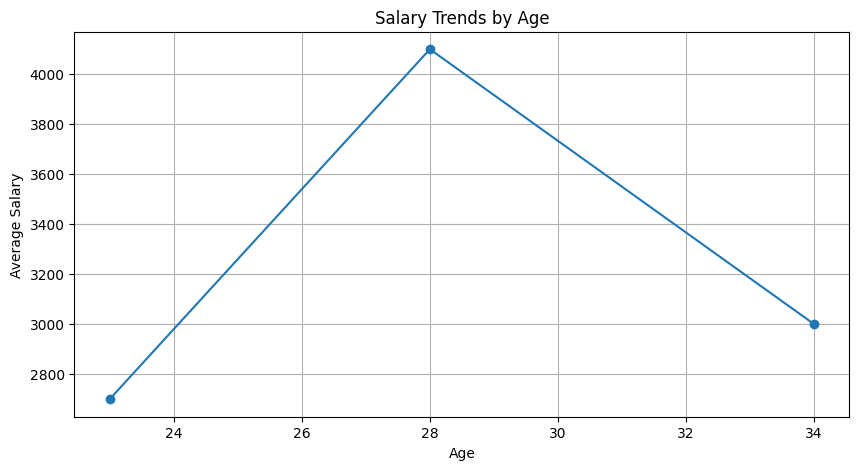

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


### 6. Homework

**Tugas 1**: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.

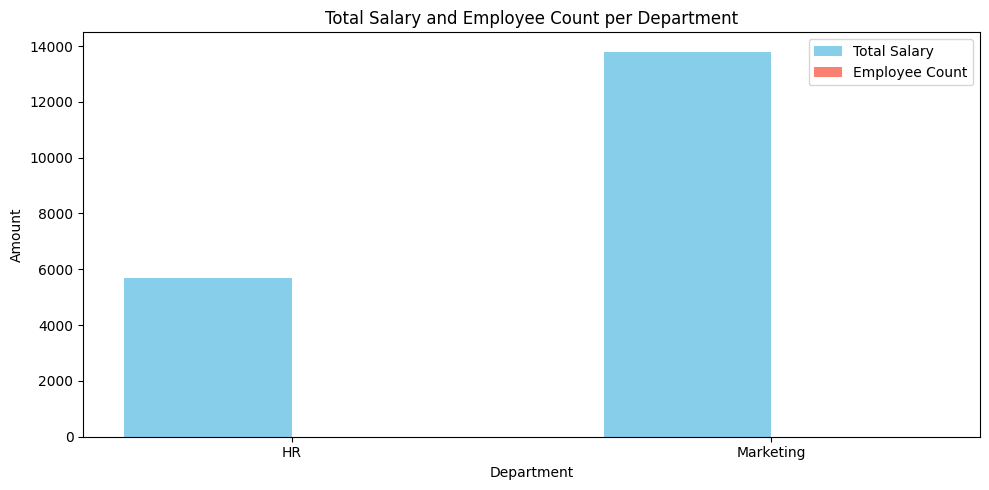

In [43]:
result = spark.sql('''
SELECT d.DeptName, 
       SUM(e.Salary) AS TotalSalary, 
       COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
''')

result_pd = result.toPandas()

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(result_pd))

# Membuat dua bar plot untuk total gaji dan jumlah karyawan
plt.bar(index, result_pd['TotalSalary'], bar_width, label='Total Salary', color='skyblue')
plt.bar([i + bar_width for i in index], result_pd['EmployeeCount'], bar_width, label='Employee Count', color='salmon')

plt.xlabel('Department')
plt.ylabel('Amount')
plt.title('Total Salary and Employee Count per Department')
plt.xticks([i + bar_width / 2 for i in index], result_pd['DeptName'])
plt.legend()
plt.tight_layout()
plt.show()

**Tugas 2**: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.

+---+------+------+------+------+---------+
|Age|  Name|Gender|Salary|DeptId|AvgSalary|
+---+------+------+------+------+---------+
| 34|  Annu|     F|  4200|     1|   3600.0|
| 28|  Anni|     M|  4150|     2|   4125.0|
| 80|zidhan|     M|  5000|     2|   4850.0|
| 23|   Lee|     M|  2700|     1|   2600.0|
+---+------+------+------+------+---------+



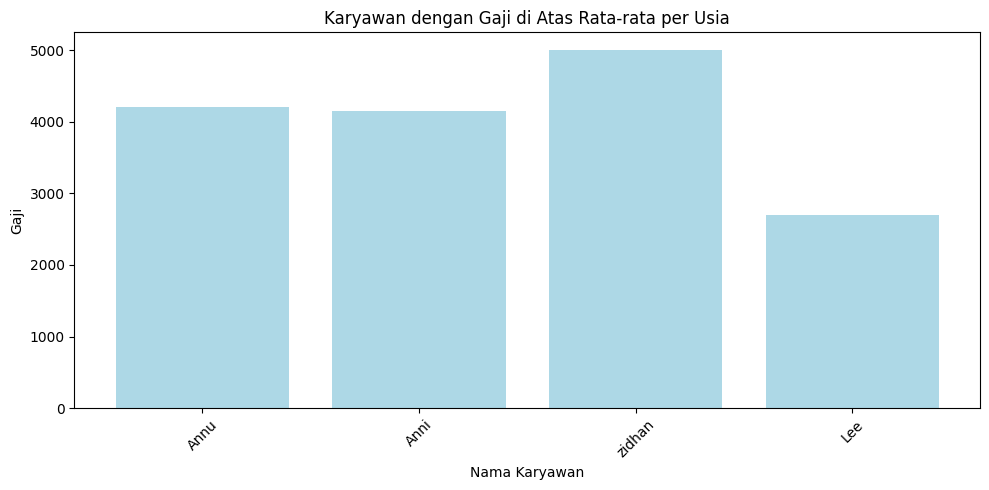

In [56]:
avg_salary = spark.sql('''
SELECT Age, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY Age
''')

above_avg_salary = (
    df.join(avg_salary, "Age")
      .filter(df.Salary > avg_salary.AvgSalary)
)
above_avg_salary.show()
above_avg_salary_pd = above_avg_salary.toPandas()

plt.figure(figsize=(10, 5))
plt.bar(above_avg_salary_pd['Name'], above_avg_salary_pd['Salary'], color='lightblue')
plt.xlabel('Nama Karyawan')
plt.ylabel('Gaji')
plt.title('Karyawan dengan Gaji di Atas Rata-rata per Usia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()